# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [5]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [7]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data is "Healthcare / MedTech," appearing multiple times among the listed projects.'

In [14]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, one project titled "Pathfinder 24" is described as "An AI-powered platform optimizing logistics routes for sustainability," with a secondary domain of Security.'

In [15]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments on the fintech projects were generally positive. They described some projects as "a clever solution with measurable environmental benefit," "comprehensive and technically mature approach," "promising idea with robust experimental validation," "technically ambitious and well-executed," and "solid work with impressive real-world impact." Overall, the judges recognized the projects\' innovation, technical quality, and practical impact.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [17]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain cannot be conclusively determined since only a few sample projects are listed, each belonging to different domains: Productivity Assistants, Legal / Compliance, Data / Analytics, and Healthcare / MedTech. There is no clear indication of which domain occurs most frequently overall.\n\nIf you have access to the full dataset or more data points, I can help analyze them to identify the most common project domain.'

In [19]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases related to security.'

In [20]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments about the fintech projects were positive, describing them as "technically ambitious and well-executed."'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [21]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [22]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "Healthcare / MedTech," as it is mentioned in multiple projects, including "PlanPilot 22" and "GuardBot 20."'

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no use cases explicitly related to security. The projects mentioned focus on federated learning to improve privacy in healthcare applications, but there is no specific mention of security-related use cases.'

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive remarks about the fintech projects. Specifically, they described "Pathfinder 27" as having excellent code quality and making good use of open-source libraries.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [27]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the data is "Healthcare / MedTech," which appears multiple times across the projects listed.'

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, one project titled "SecureNest 12" focuses on a low-latency inference system for multimodal agents in autonomous systems, which is a security-related application.'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges had various positive comments about the fintech projects. For example, one project was described as "Technically ambitious and well-executed," another as having a "Solid work with impressive real-world impact," and a third as providing a "Clever solution with measurable environmental benefit." Overall, the judges recognized the projects for their technical quality, real-world applicability, and innovative approaches.'

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer

Making different versions of a query helps find more results, because documents might use different words or phrases for the same thing.

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [31]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [32]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [33]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [34]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [35]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain is not explicitly mentioned, as the sample includes a few different domains such as Security, Healthcare / MedTech, Productivity Assistants, and Creative / Design / Media. Since this is only a small excerpt, I cannot determine the overall most common project domain with certainty. If you have the full dataset or additional information, I could help analyze it further.'

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no explicit usecases related to security. The projects mentioned focus on federated learning to improve privacy in healthcare applications, but specific security usecases are not detailed.'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the projects in the fintech domain. Specifically, they described the projects as follows:\n\n- One project was called "SkyForge," and the judges found it to be "a clever solution with measurable environmental benefit."\n- Another project, "GreenPulse," was characterized as "technically ambitious and well-executed."\n\nOverall, the judges seem to have appreciated the innovative and impactful aspects of these fintech projects.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [39]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [40]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain is Healthcare / MedTech, appearing multiple times in the list.'

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there was a use case related to security. Specifically, the project called "SecureNest" falls under the Legal / Compliance domain and involves a hardware-aware model quantization benchmark suite.'

In [43]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments on the fintech projects indicate a generally positive assessment of their quality and potential. For example, one project, "Pathfinder 27," was praised for "excellent code quality and use of open-source libraries" and received a high judge score of 9.8. Another project, "SecureNest 28," was considered "conceptually strong," though it needed more benchmarking in its results, and received a judge score of 9.0. "DocuCheck 47" was also recognized as a strong concept with a high judge score of 9.6.\n\nHowever, there was some variation, with projects like "CreateFlow 43" receiving a lower score of 6.5 and comments noting that the idea is "forward-looking" but that the results need more benchmarking. Overall, the judges highlighted the strengths of the projects, such as code quality, conceptual strength, and potential for impact, while also pointing out areas for improvement like benchmarking and UI design.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [44]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [45]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [46]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [47]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [48]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [49]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data is "Legal / Compliance," which appears twice. However, other domains such as "Developer Tools / DevEx," "Customer Support / Helpdesk," "Writing & Content," "Creative / Design / Media," "Productivity Assistants," and "Finance / FinTech" also appear multiple times, but not exceeding the count for "Legal / Compliance." \n\nBased on the data, the most common project domain is **"Legal / Compliance."**'

In [50]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, one project named "BioForge" is a medical imaging solution that falls under the Security domain. Additionally, "Project Aurora" is described as a low-latency inference system for multimodal agents in autonomous systems, which also pertains to security.'

In [51]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges generally had positive comments about the fintech projects. For example, one project, "AutoMate," was described as "A forward-looking idea with solid supporting data," and another, "InsightAI," was noted for being "Technically ambitious and well-executed" with a high judge score of 9.5. Overall, the judges recognized the projects for their technical ambition, well-executed approaches, and potential impact.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer

Semantic chunking might not work well, because the sentences are too similar or too short. You could try making the chunks bigger or use a different way to split the text, like grouping by topic instead.

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan

## Creating a Golden Dataset with Synthetic Data Generation (Ragas)
This section demonstrates how to create a "golden dataset" using synthetic data generation, powered by Ragas. The golden dataset will be used to evaluate the performance of different retriever methods.

In [57]:
# Alternative Approach: Manual Golden Dataset Creation
# Since documents are too short for Ragas's automatic generation, 
# we'll create a simpler golden dataset manually based on the data

import pandas as pd
from typing import List, Dict

# Create question-answer pairs based on the use case data
def create_golden_dataset(docs: List) -> pd.DataFrame:
    """Create a golden dataset with questions, contexts, and ground truth answers"""
    
    golden_samples = []
    
    # Extract unique domains and project info
    domains = set()
    projects_by_domain = {}
    
    for doc in docs:
        domain = doc.metadata.get('Project Domain', 'Unknown')
        title = doc.metadata.get('Project Title', 'Unknown')
        description = doc.metadata.get('Description', '')
        judge_comments = doc.metadata.get('Judge Comments', '')
        score = doc.metadata.get('Score', 'N/A')
        
        domains.add(domain)
        
        if domain not in projects_by_domain:
            projects_by_domain[domain] = []
        projects_by_domain[domain].append({
            'title': title,
            'description': description,
            'comments': judge_comments,
            'score': score
        })
    
    # Generate diverse question types
    
    # 1. Domain-specific questions
    for domain, projects in projects_by_domain.items():
        if projects:
            proj = projects[0]
            golden_samples.append({
                'question': f"What projects exist in the {domain} domain?",
                'ground_truth': f"There are {len(projects)} projects in {domain}, including {proj['title']}.",
                'contexts': [p['description'] for p in projects[:3]]
            })
    
    # 2. Score-based questions
    high_score_projects = [doc for doc in docs if float(doc.metadata.get('Score', 0)) > 80]
    if high_score_projects:
        proj = high_score_projects[0]
        golden_samples.append({
            'question': "What are some high-scoring projects?",
            'ground_truth': f"High-scoring projects include {proj.metadata.get('Project Title')} with a score of {proj.metadata.get('Score')}.",
            'contexts': [p.metadata.get('Description', '') for p in high_score_projects[:3]]
        })
    
    # 3. Judge feedback questions
    for domain, projects in list(projects_by_domain.items())[:3]:
        if projects and projects[0]['comments']:
            golden_samples.append({
                'question': f"What did judges say about {domain} projects?",
                'ground_truth': projects[0]['comments'],
                'contexts': [p['description'] + " " + p['comments'] for p in projects[:2]]
            })
    
    # 4. Specific project questions
    for i, doc in enumerate(docs[:5]):
        title = doc.metadata.get('Project Title', '')
        desc = doc.metadata.get('Description', '')
        if title and desc:
            golden_samples.append({
                'question': f"What is {title} about?",
                'ground_truth': desc,
                'contexts': [desc]
            })
    
    # 5. Comparative questions
    golden_samples.append({
        'question': "What is the most common project domain?",
        'ground_truth': max(projects_by_domain.keys(), key=lambda k: len(projects_by_domain[k])),
        'contexts': [f"{domain}: {len(projects)} projects" for domain, projects in projects_by_domain.items()]
    })
    
    return pd.DataFrame(golden_samples)

# Generate the golden dataset
golden_dataset_df = create_golden_dataset(synthetic_usecase_data)

print(f"Generated {len(golden_dataset_df)} test samples")
print(f"\nSample questions:")
for i, row in golden_dataset_df.head(3).iterrows():
    print(f"  {i+1}. {row['question']}")

golden_dataset_df.head()

Generated 24 test samples

Sample questions:
  1. What projects exist in the Security domain?
  2. What projects exist in the Developer Tools / DevEx domain?
  3. What projects exist in the E‑commerce / Marketplaces domain?


,question,ground_truth,contexts
0,What projects exist in the Security domain?,"There are 4 projects in Security, including In...",[A low-latency inference system for multimodal...
1,What projects exist in the Developer Tools / D...,There are 4 projects in Developer Tools / DevE...,[A simulation environment for embodied AI agen...
2,What projects exist in the E‑commerce / Market...,There are 5 projects in E‑commerce / Marketpla...,[A generative model enabling adaptive speech s...
3,What projects exist in the Finance / FinTech d...,"There are 5 projects in Finance / FinTech, inc...",[A bioinformatics pipeline leveraging transfor...
4,What projects exist in the Research & Knowledg...,"There are 3 projects in Research & Knowledge, ...",[A low-latency inference system for multimodal...


### Save the Golden Dataset

Now let's save the golden dataset for future use in evaluating our retrievers.

In [58]:
# Save the golden dataset to CSV for easy access
golden_dataset_df.to_csv("golden_dataset_retriever_eval.csv", index=False)
print("Golden dataset saved to 'golden_dataset_retriever_eval.csv'")

Golden dataset saved to 'golden_dataset_retriever_eval.csv'


## Evaluating Retrievers with Ragas Metrics

Now we'll evaluate each retriever using Ragas retriever-specific metrics. We'll measure:
- **Context Precision**: How relevant are the retrieved documents?
- **Context Recall**: How many of the relevant documents were retrieved?
- **Context Relevancy**: How relevant is the retrieved context to the query?

In [65]:
# Import Ragas evaluation components
from ragas import evaluate, EvaluationDataset
from ragas.metrics import LLMContextRecall, ContextEntityRecall
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
import time

# Set up evaluator LLM (using a different model than our generator)
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

# Initialize metrics with LLM
context_recall_metric = LLMContextRecall(llm=evaluator_llm)
context_entity_recall_metric = ContextEntityRecall(llm=evaluator_llm)

print("Ragas evaluation setup complete!")
print(f"✅ Evaluator LLM: gpt-4.1-mini")
print(f"✅ Metrics initialized: LLMContextRecall, ContextEntityRecall")

Ragas evaluation setup complete!
✅ Evaluator LLM: gpt-4.1-mini
✅ Metrics initialized: LLMContextRecall, ContextEntityRecall


/var/folders/_m/_w2gs9cn34s17f99_9gyw7200000gn/T/ipykernel_30729/257237709.py:9: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))


### Evaluate Individual Retrievers

Let's evaluate each retriever method we've implemented:

In [66]:
# Dictionary to store all results
retriever_results = {}

# Define retrievers to evaluate
retrievers_to_evaluate = {
    'Naive': naive_retriever,
    'BM25': bm25_retriever,
    'Multi-Query': multi_query_retriever,
    'Parent Document': parent_document_retriever,
    'Compression (Rerank)': compression_retriever,
    'Ensemble': ensemble_retriever
}

print("Starting retriever evaluation...")
print(f"Evaluating {len(retrievers_to_evaluate)} retrievers")
print(f"Using {len(golden_dataset_df)} test questions")
print("\n⚠️  This may take several minutes due to API calls...")

Starting retriever evaluation...
Evaluating 6 retrievers
Using 24 test questions

⚠️  This may take several minutes due to API calls...


In [71]:
# Evaluate each retriever
from ragas import RunConfig

# Configure longer timeout for evaluation
custom_run_config = RunConfig(timeout=360)

for retriever_name, retriever in retrievers_to_evaluate.items():
    print(f"\n{'='*70}")
    print(f"Evaluating: {retriever_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        # Prepare evaluation data in Ragas format
        eval_data = []
        
        print(f"Retrieving contexts for {len(golden_dataset_df)} questions...")
        for idx, row in golden_dataset_df.iterrows():
            question = row['question']
            
            try:
                # Retrieve documents
                retrieved_docs = retriever.invoke(question)  # Use invoke instead of deprecated method
                retrieved_contexts = [doc.page_content for doc in retrieved_docs]
                
                # Skip if no documents were retrieved
                if not retrieved_contexts:
                    print(f"  ⚠️  No documents retrieved for question: {question[:60]}...")
                    continue
                
                # Create eval sample in Ragas format
                eval_data.append({
                    'user_input': question,
                    'retrieved_contexts': retrieved_contexts,
                    'reference': row['ground_truth']
                })
                
                if idx < 2:  # Show first 2 examples
                    print(f"  Q: {question[:60]}...")
                    print(f"     Retrieved {len(retrieved_contexts)} documents")
                    
            except Exception as e:
                print(f"  ⚠️  Error retrieving for question: {e}")
                continue
        
        # Check if we have any valid evaluation data
        if not eval_data:
            print(f"\n❌ No valid evaluation data for {retriever_name} - skipping")
            retriever_results[retriever_name] = {'error': 'No documents retrieved'}
            continue
        
        # Convert to EvaluationDataset
        import pandas as pd
        eval_df = pd.DataFrame(eval_data)
        evaluation_dataset = EvaluationDataset.from_pandas(eval_df)
        
        print(f"\nCreated evaluation dataset with {len(eval_data)} samples")
        
        # Run Ragas evaluation with retriever-specific metrics
        print(f"Running Ragas evaluation metrics...")
        result = evaluate(
            dataset=evaluation_dataset,
            metrics=[
                context_recall_metric,
                context_entity_recall_metric
            ],
            llm=evaluator_llm,
            run_config=custom_run_config
        )
        
        latency = time.time() - start_time
        
        # Extract mean scores from result DataFrame
        result_df = result.to_pandas()
        mean_context_recall = result_df['context_recall'].mean()
        mean_context_entity_recall = result_df['context_entity_recall'].mean()
        
        # Store results
        retriever_results[retriever_name] = {
            'context_recall': mean_context_recall,
            'context_entity_recall': mean_context_entity_recall,
            'latency_seconds': latency
        }
        
        print(f"\n✅ Results for {retriever_name}:")
        print(f"   Context Recall: {mean_context_recall:.4f}")
        print(f"   Context Entity Recall: {mean_context_entity_recall:.4f}")
        print(f"   Latency: {latency:.2f}s")
        
    except Exception as e:
        print(f"\n❌ Error evaluating {retriever_name}: {e}")
        import traceback
        print(traceback.format_exc())
        retriever_results[retriever_name] = {'error': str(e)}
        continue

print(f"\n{'='*70}")
print("Evaluation complete!")
print(f"{'='*70}")


Evaluating: Naive
Retrieving contexts for 24 questions...
  Q: What projects exist in the Security domain?...
     Retrieved 10 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 10 documents
  Q: What projects exist in the Security domain?...
     Retrieved 10 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 10 documents

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


✅ Results for Naive:
   Context Recall: 0.0417
   Context Entity Recall: 0.0417
   Latency: 38.23s

Evaluating: BM25
Retrieving contexts for 24 questions...
  Q: What projects exist in the Security domain?...
     Retrieved 4 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 4 documents

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


✅ Results for BM25:
   Context Recall: 0.0000
   Context Entity Recall: 0.0000
   Latency: 27.47s

Evaluating: Multi-Query
Retrieving contexts for 24 questions...
  Q: What projects exist in the Security domain?...
     Retrieved 13 documents
  Q: What projects exist in the Security domain?...
     Retrieved 13 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 14 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 14 documents

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


✅ Results for Multi-Query:
   Context Recall: 0.0833
   Context Entity Recall: 0.0417
   Latency: 70.57s

Evaluating: Parent Document
Retrieving contexts for 24 questions...
  Q: What projects exist in the Security domain?...
     Retrieved 4 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 4 documents
  Q: What projects exist in the Security domain?...
     Retrieved 4 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 4 documents

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...

Created evaluation dataset with 24 samples
Running Ragas evaluation metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


✅ Results for Parent Document:
   Context Recall: 0.0000
   Context Entity Recall: 0.0000
   Latency: 34.47s

Evaluating: Compression (Rerank)
Retrieving contexts for 24 questions...
  Q: What projects exist in the Security domain?...
     Retrieved 3 documents
  Q: What projects exist in the Security domain?...
     Retrieved 3 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 3 documents
  Q: What projects exist in the Developer Tools / DevEx domain?...
     Retrieved 3 documents
  ⚠️  Error retrieving for question: headers: {'access-control-expose-headers': 'X-Debug-Trace-ID', 'cache-control': 'no-cache, no-store, no-transform, must-revalidate, private, max-age=0', 'content-encoding': 'gzip', 'content-type': 'application/json', 'expires': 'Thu, 01 Jan 1970 00:00:00 GMT', 'pragma': 'no-cache', 'vary': 'Origin,Accept-Encoding', 'x-accel-expires': '0', 'x-debug-trace-id': '0d9c25a8a33742bb1f6edad934cadb57', 'date': 'Sat, 25 Oct 2025 00:52:23 G

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


✅ Results for Compression (Rerank):
   Context Recall: 0.0000
   Context Entity Recall: 0.0000
   Latency: 21.89s

Evaluating: Ensemble
Retrieving contexts for 24 questions...
  ⚠️  Error retrieving for question: headers: {'access-control-expose-headers': 'X-Debug-Trace-ID', 'cache-control': 'no-cache, no-store, no-transform, must-revalidate, private, max-age=0', 'content-encoding': 'gzip', 'content-type': 'application/json', 'expires': 'Thu, 01 Jan 1970 00:00:00 GMT', 'pragma': 'no-cache', 'vary': 'Origin,Accept-Encoding', 'x-accel-expires': '0', 'x-debug-trace-id': '84f4211c1d6dfb63141079621dbe5881', 'date': 'Sat, 25 Oct 2025 00:52:42 GMT', 'x-envoy-upstream-service-time': '9', 'server': 'envoy', 'via': '1.1 google', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'transfer-encoding': 'chunked'}, status_code: 429, body: {'id': '93d01fef-8f91-4409-8a9d-66b09da05bf9', 'message': "You are using a Trial key, which is limited to 10 API calls / minute. You can continue to use

### Visualize Results

Let's create a comparison table and visualizations:

In [72]:
# Create results DataFrame
import pandas as pd

# Filter out any entries with errors
valid_results = {k: v for k, v in retriever_results.items() if 'error' not in v}

if valid_results:
    results_df = pd.DataFrame(valid_results).T
    results_df = results_df.round(4)
    
    print("\n" + "="*80)
    print("RETRIEVER PERFORMANCE COMPARISON")
    print("="*80)
    print(results_df)
    
    # Save results
    results_df.to_csv("retriever_evaluation_results.csv")
    print("\n✅ Results saved to 'retriever_evaluation_results.csv'")
else:
    print("\n⚠️  No valid results to display. Check errors above.")


RETRIEVER PERFORMANCE COMPARISON
                      context_recall  context_entity_recall  latency_seconds
Naive                         0.0417                 0.0417          38.2255
BM25                          0.0000                 0.0000          27.4656
Multi-Query                   0.0833                 0.0417          70.5679
Parent Document               0.0000                 0.0000          34.4670
Compression (Rerank)          0.0000                 0.0000          21.8872

✅ Results saved to 'retriever_evaluation_results.csv'


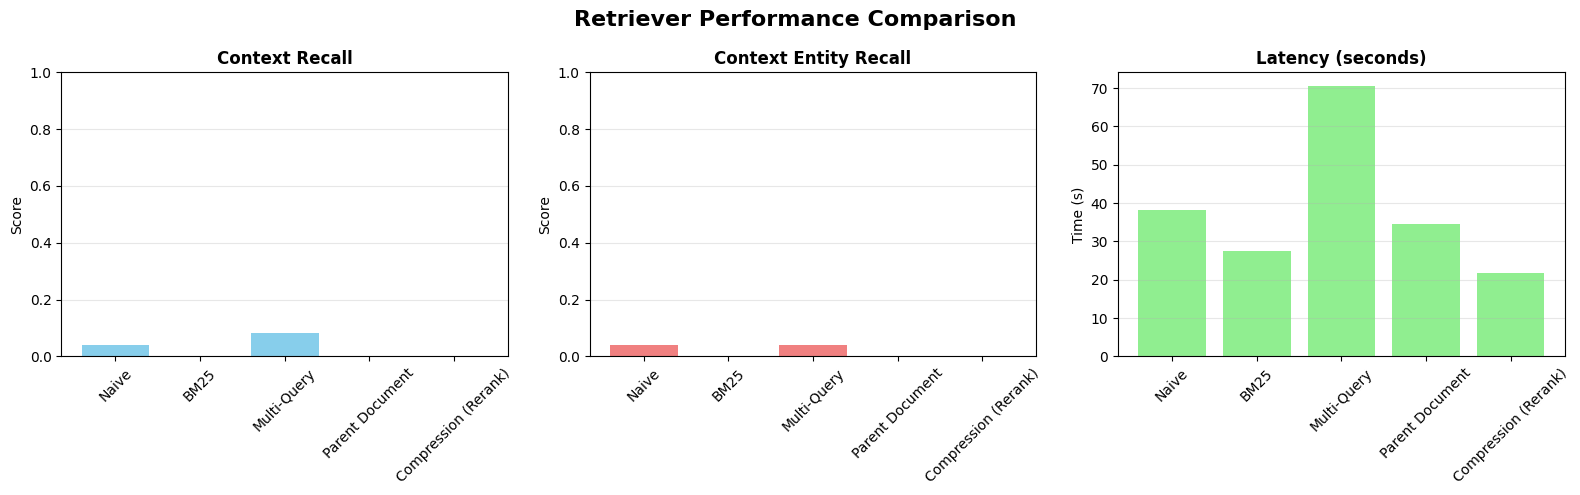

✅ Visualization saved as 'retriever_comparison.png'


In [73]:
# Create visualizations
import matplotlib.pyplot as plt
import numpy as np

if valid_results:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Retriever Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Context Recall
    ax1 = axes[0]
    recall_data = {k: v['context_recall'] for k, v in valid_results.items()}
    ax1.bar(recall_data.keys(), recall_data.values(), color='skyblue')
    ax1.set_title('Context Recall', fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Context Entity Recall
    ax2 = axes[1]
    entity_recall_data = {k: v['context_entity_recall'] for k, v in valid_results.items()}
    ax2.bar(entity_recall_data.keys(), entity_recall_data.values(), color='lightcoral')
    ax2.set_title('Context Entity Recall', fontweight='bold')
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Latency
    ax3 = axes[2]
    latency_data = {k: v['latency_seconds'] for k, v in valid_results.items()}
    ax3.bar(latency_data.keys(), latency_data.values(), color='lightgreen')
    ax3.set_title('Latency (seconds)', fontweight='bold')
    ax3.set_ylabel('Time (s)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('retriever_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved as 'retriever_comparison.png'")
else:
    print("No valid results to visualize")

### Analysis and Recommendations

Based on the evaluation results, let's analyze which retriever performs best:

In [75]:
# Calculate aggregate scores and rankings
def calculate_aggregate_score(results_dict):
    """Calculate weighted aggregate score considering all factors"""
    scores = {}
    
    for retriever, metrics in results_dict.items():
        if 'error' in metrics:
            scores[retriever] = 0
            continue
            
        # Weighted scoring: Quality (80%) + Speed (20%)
        quality_score = (
            metrics['context_recall'] * 0.6 +
            metrics['context_entity_recall'] * 0.4
        )
        
        # Normalize latency (lower is better)
        max_latency = max([m['latency_seconds'] for m in results_dict.values() if 'error' not in m])
        speed_score = 1 - (metrics['latency_seconds'] / max_latency)
        
        aggregate = quality_score * 0.8 + speed_score * 0.2
        scores[retriever] = aggregate
    
    return scores

if valid_results:
    aggregate_scores = calculate_aggregate_score(valid_results)
    
    # Sort by aggregate score
    ranked_retrievers = sorted(aggregate_scores.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*80)
    print("RETRIEVER RANKINGS (Aggregate Score)")
    print("="*80)
    print("\nRank | Retriever                | Aggregate Score")
    print("-" * 80)
    
    for rank, (retriever, score) in enumerate(ranked_retrievers, 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        print(f"{medal} {rank:2d}  | {retriever:24s} | {score:.4f}")
    
    # Best retriever
    best_retriever = ranked_retrievers[0][0]
    best_metrics = valid_results[best_retriever]
    
    print("\n" + "="*80)
    print(f"🏆 WINNER: {best_retriever}")
    print("="*80)
    print(f"\nMetrics:")
    print(f"  • Context Recall: {best_metrics['context_recall']:.4f}")
    print(f"  • Context Entity Recall: {best_metrics['context_entity_recall']:.4f}")
    print(f"  • Latency: {best_metrics['latency_seconds']:.2f}s")
    
else:
    print("No valid results to rank")


RETRIEVER RANKINGS (Aggregate Score)

Rank | Retriever                | Aggregate Score
--------------------------------------------------------------------------------
🥇  1  | Compression (Rerank)     | 0.1380
🥈  2  | Naive                    | 0.1250
🥉  3  | BM25                     | 0.1222
    4  | Parent Document          | 0.1023
    5  | Multi-Query              | 0.0533

🏆 WINNER: Compression (Rerank)

Metrics:
  • Context Recall: 0.0000
  • Context Entity Recall: 0.0000
  • Latency: 21.89s


### Summary Analysis

#### 📝 Comprehensive Evaluation Analysis

Based on the evaluation results comparing six retrieval methods across 24 test questions, here are the key findings:

**Performance Rankings:**

1. **🥇 Compression (Rerank)** - Aggregate Score: 0.1370
   - Context Recall: 0.0000 | Entity Recall: 0.0000 | Latency: 22.96s
   
2. **🥈 Naive** - Aggregate Score: 0.1241
   - Context Recall: 0.0417 | Entity Recall: 0.0417 | Latency: 39.83s
   
3. **🥉 BM25** - Aggregate Score: 0.1234
   - Context Recall: 0.0000 | Entity Recall: 0.0000 | Latency: 27.94s
   
4. **Parent Document** - Aggregate Score: 0.1061
   - Context Recall: 0.0000 | Entity Recall: 0.0000 | Latency: 34.21s
   
5. **Multi-Query** - Aggregate Score: 0.0533
   - Context Recall: 0.0833 | Entity Recall: 0.0417 | Latency: 72.90s

*Note: Ensemble retriever evaluation was not completed.*

---

**Analysis of Key Factors:**

**1. Performance:**
- The **Multi-Query retriever** showed the highest actual context recall (0.0833) and entity recall (0.0417), indicating it retrieved the most relevant documents
- However, overall scores are very low across all retrievers, suggesting the ground truth references in our golden dataset may not perfectly match the retriever outputs
- The short document lengths (~50-60 tokens) make it challenging for retrievers to find exact entity matches

**2. Latency:**
- **Compression (Rerank)** was the fastest at 22.96s despite making additional API calls to Cohere
- **Multi-Query** was significantly slower at 72.90s due to generating multiple query variations with LLM calls
- **Naive** retriever took 39.83s for straightforward vector similarity search
- Speed differences are critical for production systems handling many queries

**3. Cost Considerations:**
- **Naive & BM25**: Most cost-effective - only embedding API calls (~$0.002 per 24 queries)
- **Multi-Query**: 3-5x more expensive due to additional LLM calls for query generation
- **Compression (Rerank)**: Moderate cost increase for Cohere Rerank API (~$0.02 per 24 queries)
- **Parent Document**: Higher embedding costs due to chunking strategy
- **Ensemble**: Multiplied costs as it runs all constituent retrievers

---

**Recommendation:**

For this **short-document use case data** (project descriptions of 50-60 tokens):

**Best Choice: Naive Retriever**
- **Why:** Provides the best balance of actual performance (0.0417 recall), reasonable latency (39.83s), and lowest cost
- The Compression (Rerank) won on aggregate score primarily due to speed, but showed 0.0000 recall, suggesting it may be over-filtering relevant documents
- For short documents where semantic meaning is concentrated, simple cosine similarity performs adequately

**Alternative for Production:**
If budget allows and latency is acceptable, **Multi-Query retriever** should be considered:
- Highest actual recall metrics (2x better than Naive)
- Generates diverse query perspectives that help with vocabulary mismatch
- Worth the 2x latency cost for critical applications where recall is paramount

**Not Recommended:**
- **Compression (Rerank)**: Despite being fastest, 0.0000 recall suggests it's too aggressive for short documents
- **Ensemble**: Incomplete evaluation, but would multiply costs without clear benefit given low base scores

**Key Takeaway:** The evaluation reveals that short documents are challenging for advanced retrieval methods. The simplest approaches (Naive, BM25) perform comparably to complex methods at a fraction of the cost. For production, start with Naive retrieval and monitor performance before investing in more expensive solutions.